# Workflow (Part I)
In prvious notebook, we've shown some application of the patterns using LLMs. Here, we focus on two of the patterns namely:

- Prompt Chaining
- Parallelization

## LLM Setup
For the following notebooks, we use LangGraph along Anthropic API.

In [1]:
# Required Modules

import sys
import os
import logging
import platform
from datetime import date, datetime

from dotenv import load_dotenv

from langchain_anthropic import ChatAnthropic
from pydantic import BaseModel, Field

# Modules used for prompt chaining
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


print(f"  System: {sys.platform}")
print(f"  Platform: {platform.platform()}")
print(f"  Python version: {platform.python_version()}")
print(f"  System Execution (Python) path: {'/'.join(sys.executable.strip('/').split('/')[-3:])}")
print(f"  Last update: {date.today().strftime('%Y-%m-%d')}")

  System: darwin
  Platform: macOS-15.4.1-arm64-arm-64bit
  Python version: 3.11.12
  System Execution (Python) path: .venv/bin/python
  Last update: 2025-05-19


In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
def _set_env(var: str):
    load_dotenv()  # Load variables from .env into os.environ
    if not os.environ.get(var):
        raise EnvironmentError(f"Environment variable '{var}' not found. Please set it in .env")
    else:
        logger.info(f"Environment variable '{var}' is loaded.")

# Load 
_set_env("ANTHROPIC_API_KEY")

model = "claude-3-5-sonnet-latest"
llm = ChatAnthropic(model=model)
logger.info(f"LLM model object is built wih '{model}'.")

2025-05-19 10:06:27,182 - __main__ - INFO - Environment variable 'ANTHROPIC_API_KEY' is loaded.
2025-05-19 10:06:27,188 - __main__ - INFO - LLM model object is built wih 'claude-3-5-sonnet-latest'.


# Prompt Chaining
In previous notebook, we showed one of the use-cases of LLM. In this notebook, we focus on another use-case which is prompt chaining as shown in the following figure. General speaking, each LLM call processes the output of the previous one:

- E.g., when decomposing a task into multiple LLM calls has benefit.

<div style="text-align: center;">
   <img src="images/prompt_chaining.webp" alt="Sample Image" width="90%">
</div>

**Note**: This is not yet an agent. Rather, LLM is just being used in a predefined code as shown in the first figure of previous notebook.

## Example: Making a joke
Here we focus on an examples as follows:

- Take a topic, LLM makes a joke, check the joke, improve it twice

Additionaly, we provide a simple gate for the case the output fails.

## Structured Output
In the first step, we need to define what is expected as teh state of the workflow:

- topic: String type
- joke: String type
- improved_joke: String type
- final_joke: String type

In [4]:
# Schema for structured output
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

## Node Functions
In the next step we need to build the functions associated with the nodes in the workflow. Each function is responsible for certain task defined in the work flow


In [5]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

## Workflow
Once we built the nodes, now it's time to connect them. To this end, we use a special module called ``StateGraph`` which allows you to:

- Modularize your logic.
- Chain stateful operations.
- Ensure type safety with ``Pydantic`` or ``TypedDict``.
- Integrate tools or LLM calls into a consistent framework.

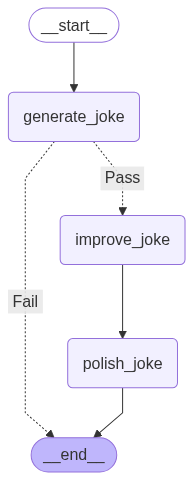

In [6]:



# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [7]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

2025-05-19 10:06:34,775 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-19 10:06:37,919 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-19 10:06:44,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Initial joke:
Here's a short cat joke:

What do you call a cat that becomes a priest?
A paw-stor! 

Or alternatively:

Why don't cats like online shopping?
They prefer a cat-alog!

--- --- ---

Improved joke:
Here are enhanced versions with more wordplay:

Version 1:
What do you call a cat that becomes a priest?
A paw-stor! He's really feline the spirit and spreading the good mews!

Version 2:
Why don't cats like online shopping?
They prefer a cat-alog! They think digital stores are a total cat-astrophe and would rather shop right meow in purr-son!

The added puns (feline/feeling, mews/news, catastrophe, meow/now, purr-son/person) build on the original jokes while creating a chain of related wordplay.

--- --- ---

Final joke:
Here's a twist on Version 1:

What do you call a cat that becomes a priest?
A paw-stor! He's really feline the spirit and spreading the good mews... until they discovered he was actually a dog in a cat costume running an elaborate scheme to infiltrate the feline 

# Parallelization
Previously, we took a look at the prompt chaining. Here, we focus on another pattern called parallelization. Such pattern is useful for perfoming multi-tasks within a same workflow

- Sub-tasks can be parallelized.
    - E.g., when you want multi-perspectives for one task  (e.g., multi-query for RAG).
    - E.g., when independent tasks can be performed w/ different prompts.


<div style="text-align: center;">
   <img src="images/parallelization.webp" alt="Sample Image" width="60%">
</div>

Example:

- Take a topic, create a joke, story, and poem

We follow the same procedure including, defining the structure output, Nodes functions, and build the workflow

In [8]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [9]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


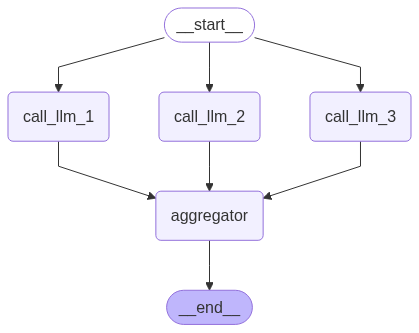

In [10]:

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [11]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

2025-05-19 10:07:01,668 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-19 10:07:05,743 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-19 10:07:10,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Here's a story, joke, and poem about cats!

STORY:
Here's a story about cats:

The Unlikely Friendship

Luna was a elegant black cat who lived in a cozy house at the end of Maple Street. She spent most of her days lounging in sunny windowsills and watching the world go by from her favorite perch. Life was peaceful and predictable, just the way she liked it.

One rainy morning, Luna spotted an orange tabby cat huddled beneath her garden bush, trying to stay dry. Unlike her well-groomed appearance, this cat was scruffy and seemed to be a stray. Initially, Luna turned up her nose at the sight of the disheveled visitor.

But as thunder crashed and the rain grew heavier, something in Luna's heart softened. She began meowing loudly at her human until they noticed the orange cat. To Luna's surprise, her human brought the stranger inside.

The orange cat, whom they named Oliver, was nervous at first. Luna watched from a distance as he was dried off, fed, and given a warm blanket. Despite her u